In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from typing import List, Union
from collections import OrderedDict
import itertools
from qiskit.quantum_info import Statevector
import multiprocessing as mp
from math import pi
from scipy.special import logsumexp

In [4]:
def final_circuit(circuit, data, params):
    d = len(params)
    layers = d//num_qubits
    
    for i in range(num_qubits):
        circuit.h(i)
    for j in range(layers-1):
        for i in range(num_qubits):
            circuit.rz(data[i],i)
            circuit.ry(data[i+2],i)
            #print(i+num_qubits*j)
            circuit.ry(params[i+num_qubits*j], i)
        circuit.cx(0,1)
    
    for i in range(num_qubits):
        circuit.rz(data[i],i)
        circuit.ry(data[i+2],i)
        #print(i+num_qubits*(layers-1))
        circuit.ry(params[i+num_qubits*(layers-1)], i)

In [5]:
def _parity():
    y1 = []
    y2 = []
    basis_states = [list(i) for i in itertools.product([0, 1], repeat=num_qubits)]
    for idx, k in enumerate(basis_states):
        parity = sum(int(k[i]) for i in range(len(k)))
        if parity % 2 == 0:
            y1.append(idx)
        else:
            y2.append(idx)
    return {'y1': y1, 'y2': y2}

In [6]:
def get_probabilities(params, x):
    
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
    params = np.array(params)
    x = np.array(x)      
    
     # specify number of parallel processes
    num_processes = 2

        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()
    probabilities = []
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities += [results[start:end]]

    return probabilities

In [7]:
def get_gradient(params, x):
    grads = []
    qc_plus = []
    qc_minus = []
    zeros = np.zeros(np.shape(params))
    for i in range(d):
        #print(i)
        zeros[:, i] = np.pi / 2.
        qc_plus += [get_probabilities(params+zeros, x)]
        qc_minus += [get_probabilities(params-zeros, x)]
        zeros[:, i] = 0
        grads.append((np.array(qc_plus[i]) - np.array(qc_minus[i])) * 0.5)
    grads = np.array(grads)
    print(grads)
        # reshape the dp_thetas
    full = np.zeros((len(x), d, 2**num_qubits))
    for j in range(len(x)):
        row = np.zeros((d, 2**num_qubits))
        for i in range(d):
            tensor = grads[i]
            row[i] += tensor[j]
        full[j] += row
    return full

In [8]:
def forward(params, x):
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
        # map input to arrays
    params = np.array(params)
    x = np.array(x)
        # specify number of parallel processes
    num_processes = 2
        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()

    aggregated_results = np.zeros((len(x), outputsize))
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities = results[start:end]
        temp_ = []
        for y in post_processing.keys():
            index = post_processing[y]  # index for each label
            temp_.append([sum(probabilities[u] for u in index)])
        temp_ = np.reshape(temp_, (1, outputsize))
        aggregated_results[i] = temp_
    return aggregated_results

In [9]:
def get_fisher(gradients, model_output):
    gradvectors = []
    for k in range(len(gradients)):
        jacobian = []
        m_output = model_output[k]  # p_theta size: (1, outputsize)
        jacobians_ = gradients[k, :, :]  # dp_theta size: (d, 2**num_qubits)
        for idx, y in enumerate(post_processing.keys()):
            index = post_processing[y]  # index for each label
            denominator = m_output[idx]  # get correct model output sum(p_theta) for indices
            for j in range(d):
                row = jacobians_[j, :]
                    # for each row of a particular dp_theta, do sum(dp_theta)/sum(p_theta) for indices
                    # multiply by sqrt(sum(p_theta)) so that the outer product cross term is correct
                jacobian.append(np.sqrt(denominator)*(sum(row[u] for u in index) / denominator))
            # append gradient vectors for every output for all data points
        gradvectors.append(np.reshape(jacobian, (outputsize, d)))
        print(np.reshape(jacobian, (outputsize, d)))
        # full gradient vector
    gradients = np.reshape(gradvectors, (len(gradients), outputsize, d))

    fishers = np.zeros((len(gradients), d, d))
    for i in range(len(gradients)):
        grads = gradients[i]  # size = (outputsize, d)
        temp_sum = np.zeros((outputsize, d, d))
        for j in range(outputsize):
            temp_sum[j] += np.array(np.outer(grads[j], np.transpose(grads[j])))
        fishers[i] += np.sum(temp_sum, axis=0)  # sum the two matrices to get fisher estimate
    return fishers

In [10]:
d = 2
num_qubits = 2
inputsize = 4
outputsize = 2
post_processing = OrderedDict(_parity())
sv = Statevector.from_label('0' * num_qubits)

num_inputs = 100
num_thetas = 100
thetamin = -1
thetamax = 1

rep_range = np.tile(np.array([num_inputs]), num_thetas)
params_ = np.random.uniform(thetamin, thetamax, size=(num_thetas, d))
params = np.repeat(params_, repeats=rep_range, axis=0)
x_ = np.random.normal(0, 1, size=(num_inputs, inputsize))
x = np.tile(x_, (num_thetas, 1))

In [11]:
def get_fhat():
    grads = get_gradient(params, x)
    output = forward(params, x)
    fishers = get_fisher(grads, output)
    fisher_trace = np.trace(np.average(fishers, axis=0))
    fisher = np.average(np.reshape(fishers, (num_thetas, num_inputs, d, d)), axis=1)
    f_hat = d * fisher / fisher_trace
    return f_hat, fisher_trace

In [12]:
def eff_dim(f_hat, n):
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return np.array(effective_dim)/d

In [13]:
n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

###################################################################################

f, trace = get_fhat()

[[[-0.02564952  0.02564952 -0.01975137  0.01975137]
  [ 0.01827953 -0.01827953  0.02084699 -0.02084699]
  [ 0.02211983 -0.02211983  0.03196829 -0.03196829]
  ...
  [ 0.1944569  -0.1944569   0.18396345 -0.18396345]
  [-0.06674562  0.06674562 -0.02898372  0.02898372]
  [-0.01098337  0.01098337 -0.01271058  0.01271058]]

 [[-0.40349526 -0.06999229  0.40349526  0.06999229]
  [-0.18898777 -0.2854493   0.18898777  0.2854493 ]
  [-0.12418382 -0.01661566  0.12418382  0.01661566]
  ...
  [-0.04452631 -0.02937547  0.04452631  0.02937547]
  [-0.17736542 -0.20372795  0.17736542  0.20372795]
  [ 0.00411394  0.00361871 -0.00411394 -0.00361871]]]
[[-0.00798395 -0.45144198]
 [ 0.00875123  0.49482691]]
[[-0.00360696  0.1355162 ]
 [ 0.00365541 -0.13733643]]
[[-0.01501096 -0.1639548 ]
 [ 0.01304971  0.14253335]]
[[-0.00367752  0.0086801 ]
 [ 0.00363164 -0.00857182]]
[[ 0.20944209 -0.159967  ]
 [-0.39577472  0.30228353]]
[[ 0.12982201  0.02857123]
 [-0.20149214 -0.04434439]]
[[ 0.00199825 -0.22446294]
 [-

[[ 0.00596534  0.03963168]
 [-0.00580047 -0.03853634]]
[[-0.08235222  0.07003386]
 [ 0.02961728 -0.02518708]]
[[-0.37259504 -0.00432364]
 [ 0.38952057  0.00452005]]
[[-0.12336006 -0.33368015]
 [ 0.08649801  0.23397095]]
[[-0.34057847  0.32544922]
 [ 0.1508961  -0.14419296]]
[[-0.21284602  0.20874388]
 [ 0.17266465 -0.16933691]]
[[-0.36964108 -0.0321463 ]
 [ 0.33986961  0.02955718]]
[[-0.01551628  0.01620928]
 [ 0.01412916 -0.01476021]]
[[-0.58368233  0.2724798 ]
 [ 0.40294049 -0.18810428]]
[[-0.09385206 -0.11099083]
 [ 0.13219367  0.15633418]]
[[-0.32488692  0.01394935]
 [ 0.76525359 -0.03285694]]
[[ 0.11018391  0.26677491]
 [-0.09141713 -0.2213372 ]]
[[ 0.33054777  0.01096398]
 [-0.4605761  -0.01527691]]
[[-0.0195406   0.31723775]
 [ 0.02643456 -0.42915981]]
[[-0.00660109 -0.00599998]
 [ 0.00659284  0.00599248]]
[[-0.21850924  0.00481574]
 [ 0.22365371 -0.00492912]]
[[ 0.10893018 -0.03103689]
 [-0.11247309  0.03204635]]
[[ 0.67451375  0.29152296]
 [-0.17836203 -0.07708757]]
[[-0.11098

 [-0.21887801  0.22612309]]
[[-0.35842745  0.02926253]
 [ 0.34871976 -0.02846998]]
[[-0.07274108 -0.12977085]
 [ 0.09686319  0.17280495]]
[[-0.04630586  0.03978853]
 [ 0.08366394 -0.07188863]]
[[ 0.0050734  -0.02289277]
 [-0.00508027  0.02292377]]
[[ 0.00514365 -0.28573488]
 [-0.00477841  0.26544522]]
[[-0.10431316 -0.07219015]
 [ 0.10866524  0.07520201]]
[[-0.04817328 -0.00087076]
 [ 0.04853381  0.00087728]]
[[-0.11177389 -0.02313523]
 [ 0.11291787  0.02337202]]
[[-0.26042505  0.11430707]
 [ 0.436115   -0.19142178]]
[[-0.07196308 -0.3399067 ]
 [ 0.07826947  0.36969398]]
[[-0.09543753 -0.00775683]
 [ 0.09256988  0.00752375]]
[[-0.04898554 -0.09242305]
 [ 0.05774309  0.10894627]]
[[-2.83348360e-01  1.21877084e-04]
 [ 2.82893713e-01 -1.21681526e-04]]
[[ 0.12355761  0.18980095]
 [-0.25361627 -0.38958839]]
[[-0.06043563 -0.0700075 ]
 [ 0.07408645  0.08582036]]
[[-0.17152812 -0.17757573]
 [ 0.25522142  0.26421982]]
[[ 0.06836625  0.0129916 ]
 [-0.06644972 -0.01262741]]
[[-0.11437111 -0.0068

 [-0.02204708  0.10673932]]
[[-0.00878924 -0.61152146]
 [ 0.00842855  0.58642583]]
[[-0.11533856 -0.28466991]
 [ 0.10578016  0.26107857]]
[[-0.1127694  -0.05597294]
 [ 0.16399447  0.08139844]]
[[ 0.19179031 -0.15047538]
 [-0.23031851  0.18070395]]
[[-0.33232023 -0.05096868]
 [ 0.34838178  0.05343208]]
[[-0.04443424 -0.14020331]
 [ 0.05977077  0.18859465]]
[[ 0.00036514  0.03303302]
 [-0.00066681 -0.06032475]]
[[ 0.00229362 -0.00416831]
 [-0.00229387  0.00416877]]
[[-0.00352802 -0.28664956]
 [ 0.00324717  0.26383042]]
[[-0.09210331 -0.11177421]
 [ 0.09775643  0.11863469]]
[[-0.04638706 -0.00235263]
 [ 0.04721513  0.00239462]]
[[-0.10010122 -0.07746303]
 [ 0.10332052  0.07995428]]
[[-0.21260667  0.11937331]
 [ 0.38998267 -0.21896549]]
[[-0.05376515 -0.40247497]
 [ 0.05855913  0.43836177]]
[[-0.09741076 -0.00233739]
 [ 0.09643956  0.00231408]]
[[-0.03143273 -0.10013004]
 [ 0.03727984  0.11875622]]
[[-0.27132526 -0.00531243]
 [ 0.28786929  0.00563636]]
[[ 0.17829688  0.17151824]
 [-0.34721

 [ 0.08767388  0.01444274]]
[[ 0.00031573 -0.16648852]
 [-0.00031729  0.16730788]]
[[-0.13744704 -0.10779308]
 [ 0.15454286  0.12120051]]
[[ 0.31600303 -0.09235996]
 [-0.5185957   0.15157284]]
[[ 0.00344711 -0.16756592]
 [-0.00365802  0.17781843]]
[[-0.00368831 -0.41126757]
 [ 0.00384771  0.42904119]]
[[ 0.00959205  0.06001296]
 [-0.00945714 -0.05916889]]
[[-0.0398053  -0.0719058 ]
 [ 0.04191039  0.07570851]]
[[-0.00173917  0.00086149]
 [ 0.00173008 -0.00085699]]
[[ 0.46841763 -0.00207809]
 [-0.48784865  0.00216429]]
[[-0.13872923  0.01226269]
 [ 0.13080853 -0.01156256]]
[[ 0.12921995  0.02730644]
 [-0.12440144 -0.0262882 ]]
[[-0.00993919  0.0032845 ]
 [ 0.01000868 -0.00330746]]
[[ 0.31389403 -0.29779927]
 [-0.2340281   0.22202844]]
[[ 0.02695804 -0.17634328]
 [-0.0263368   0.17227951]]
[[ 0.212724   -0.01567264]
 [-0.23466736  0.01728933]]
[[ 2.93672602e-05 -1.28735768e-02]
 [-2.92330980e-05  1.28147647e-02]]
[[ 0.15310669 -0.13867518]
 [-0.2408862   0.21818078]]
[[-0.25270392 -0.2363

 [ 0.01535235  0.07599725]]
[[-0.093739   -0.58959967]
 [ 0.03403653  0.21408298]]
[[-0.00783499 -0.04632731]
 [ 0.00792991  0.04688854]]
[[ 0.11123667 -0.31005668]
 [-0.10222452  0.28493656]]
[[-0.21303129  0.14852292]
 [ 0.26842298 -0.18714136]]
[[ 0.10643468 -0.16454081]
 [-0.09940942  0.15368023]]
[[-0.09783265  0.18458197]
 [ 0.0873772  -0.16485554]]
[[-0.03631513 -0.26843729]
 [ 0.03957947  0.29256694]]
[[ 0.00411838  0.06661202]
 [-0.00452918 -0.07325634]]
[[ 0.71133967  0.21371933]
 [-0.42869444 -0.12879963]]
[[ 0.0007809   0.00167694]
 [-0.00078424 -0.00168409]]
[[ 0.07323089  0.15917824]
 [-0.08843207 -0.19222027]]
[[-0.20838629 -0.35430249]
 [ 0.15342241  0.26085182]]
[[ 0.01274512  0.00333843]
 [-0.01279787 -0.00335225]]
[[ 0.02355675  0.00882664]
 [-0.02415929 -0.00905241]]
[[ 0.01541651 -0.69410293]
 [-0.00833747  0.37538107]]
[[ 0.1620448  -0.27035255]
 [-0.12322091  0.20557948]]
[[ 0.40289012 -0.54545101]
 [-0.20727153  0.28061365]]
[[-0.03878171  0.24649823]
 [ 0.03473

 [-0.2462099   0.01843082]]
[[-0.07905115  0.03667675]
 [ 0.07749284 -0.03595375]]
[[ 0.05062478 -0.01854011]
 [-0.0447345   0.01638293]]
[[ 0.15320957 -0.06590573]
 [-0.2489204   0.10707739]]
[[-0.06153304 -0.16358027]
 [ 0.06376709  0.1695193 ]]
[[ 0.48728125 -0.06432912]
 [-0.36374029  0.04801969]]
[[-0.06650136  0.16630556]
 [ 0.06397283 -0.15998225]]
[[ 0.00721663  0.00488339]
 [-0.00720277 -0.004874  ]]
[[-0.01626231  0.01483906]
 [ 0.01592808 -0.01453408]]
[[-0.02866983  0.12700048]
 [ 0.02184501 -0.09676815]]
[[ 0.00625015  0.03854195]
 [-0.00641722 -0.03957222]]
[[-0.23885396  0.42974906]
 [ 0.16856534 -0.30328488]]
[[-0.13466714 -0.19915858]
 [ 0.16039619  0.23720914]]
[[-0.39488029  0.01765769]
 [ 0.29145299 -0.01303278]]
[[-0.13787461  0.30191378]
 [ 0.12267747 -0.26863553]]
[[ 0.09556121  0.01484949]
 [-0.09607625 -0.01492953]]
[[-0.29809807 -0.06705034]
 [ 0.37494702  0.08433575]]
[[-0.02161409  0.04300494]
 [ 0.0210331  -0.04184897]]
[[ 0.04356077 -0.08818594]
 [-0.04322

[[ 0.42484286  0.07979936]
 [-0.48664309 -0.09140746]]
[[-0.41551689 -0.00775632]
 [ 0.38784322  0.00723974]]
[[ 0.28611916  0.06003411]
 [-0.32380025 -0.06794044]]
[[ 0.00839468  0.27136565]
 [-0.00916616 -0.29630427]]
[[ 0.13895422 -0.09184198]
 [-0.13111656  0.08666166]]
[[-0.0553084   0.01164295]
 [ 0.06160267 -0.01296796]]
[[ 0.30334084 -0.08807072]
 [-0.32464321  0.09425556]]
[[-0.00157629 -0.00043061]
 [ 0.00158334  0.00043254]]
[[-0.03663259  0.05896867]
 [ 0.05226643 -0.08413497]]
[[ 0.01816087 -0.24000119]
 [-0.00855076  0.11300085]]
[[ 0.01132175  0.00329632]
 [-0.01157722 -0.0033707 ]]
[[ 0.00668103 -0.00573186]
 [-0.0069911   0.00599787]]
[[ 0.64377648 -0.16618192]
 [-0.31504576  0.08132467]]
[[ 0.37251518 -0.02042091]
 [-0.33331299  0.01827189]]
[[ 0.71209567 -0.01357806]
 [-0.54763636  0.01044219]]
[[-0.02230586  0.23391931]
 [ 0.02508714 -0.2630863 ]]
[[ 0.22182677 -0.00504458]
 [-0.21742846  0.00494456]]
[[ 0.40922674  0.02767087]
 [-0.43304025 -0.02928108]]
[[-0.05136

 [ 0.04646317  0.29213675]]
[[ 0.0282856   0.10736567]
 [-0.02985823 -0.11333498]]
[[-0.12975421 -0.05109872]
 [ 0.12009022  0.04729293]]
[[-0.00673788  0.00187094]
 [ 0.00672733 -0.00186801]]
[[ 0.39996456  0.01021439]
 [-0.39361838 -0.01005232]]
[[ 0.32322269 -0.00329532]
 [-0.33357787  0.0034009 ]]
[[-0.04275707 -0.19086032]
 [ 0.03959202  0.1767321 ]]
[[ 0.00751517  0.00320129]
 [-0.0074074  -0.00315538]]
[[ 0.01904902 -0.40558251]
 [-0.01397871  0.29762792]]
[[ 0.44240809 -0.0575673 ]
 [-0.40627311  0.05286532]]
[[-0.05145129  0.27172595]
 [ 0.08669561 -0.45785919]]
[[-0.13557177 -0.21788034]
 [ 0.17786944  0.28585784]]
[[ 0.02594616 -0.03090588]
 [-0.02484042  0.02958878]]
[[ 0.32667303 -0.00291519]
 [-0.37756942  0.00336938]]
[[ 0.08376151  0.09578717]
 [-0.09003933 -0.10296629]]
[[ 0.06307617  0.04173155]
 [-0.05851146 -0.03871151]]
[[ 0.02684912 -0.2969279 ]
 [-0.03447529  0.38126681]]
[[ 0.29020989 -0.01008561]
 [-0.28680166  0.00996717]]
[[ 0.40688735  0.02679569]
 [-0.38465

 [-0.30717959  0.18108432]]
[[ 0.26212895 -0.03295716]
 [-0.22747279  0.02859988]]
[[-0.49027286  0.30038101]
 [ 0.35529134 -0.21768036]]
[[ 0.01850154  0.46167243]
 [-0.01921178 -0.4793952 ]]
[[ 0.03161097  0.38257263]
 [-0.04059016 -0.49124353]]
[[-0.00045044 -0.12391611]
 [ 0.00045158  0.12423078]]
[[ 0.52565582 -0.21216291]
 [-0.37550839  0.15156106]]
[[-0.02083845  0.02047869]
 [ 0.02062191 -0.02026589]]
[[ 0.01514584  0.37445332]
 [-0.01539964 -0.38072798]]
[[-0.2162733  -0.19942153]
 [ 0.18078905  0.16670217]]
[[ 0.03628623  0.25192015]
 [-0.03802415 -0.26398583]]
[[ 0.05640757  0.26149502]
 [-0.04503269 -0.20876319]]
[[-0.12562277  0.04831007]
 [ 0.12227735 -0.04702353]]
[[-0.04789398  0.03554718]
 [ 0.04959541 -0.03680999]]
[[ 0.43829037 -0.08425469]
 [-0.78308889  0.15053699]]
[[-0.00219472  0.00136336]
 [ 0.00220001 -0.00136665]]
[[-0.06462964  0.17192314]
 [ 0.07409733 -0.19710844]]
[[ 0.10832195 -0.44103559]
 [-0.08316571  0.3386113 ]]
[[ 0.00185012  0.01658425]
 [-0.00187

 [-0.00189159 -0.01787666]]
[[-0.00407314  0.02264641]
 [ 0.00421012 -0.02340798]]
[[ 0.21815361 -0.25852603]
 [-0.19039723  0.22563293]]
[[ 0.13057215  0.05615596]
 [-0.13473817 -0.05794766]]
[[ 0.32520504  0.05222774]
 [-0.34056143 -0.05469397]]
[[ 0.10931607  0.18980907]
 [-0.09118594 -0.15832914]]
[[ 0.05894523  0.06987524]
 [-0.06062474 -0.07186618]]
[[-0.00289768  0.23971042]
 [ 0.00289151 -0.23920022]]
[[-0.43847007 -0.01135094]
 [ 0.45178789  0.0116957 ]]
[[ 0.29259584 -0.38293049]
 [-0.18763337  0.2455624 ]]
[[ 0.12702868  0.02309814]
 [-0.13197918 -0.02399831]]
[[ 0.33223176 -0.53443168]
 [-0.19390212  0.3119131 ]]
[[-0.13787279 -0.57240113]
 [ 0.06540816  0.27155253]]
[[-0.16501325 -0.04873654]
 [ 0.1737111   0.05130544]]
[[-0.00145897 -0.39572894]
 [ 0.00143783  0.3899945 ]]
[[ 0.0525403   0.42794509]
 [-0.05673758 -0.46213224]]
[[-0.05086359 -0.1106102 ]
 [ 0.05268299  0.11456675]]
[[-0.21700555 -0.1185212 ]
 [ 0.29196905  0.15946377]]
[[-0.04920145 -0.08028114]
 [ 0.04512

[[-0.01480401  0.14643873]
 [ 0.01472373 -0.14564466]]
[[ 0.01542022  0.40904278]
 [-0.01492185 -0.39582281]]
[[-0.31104748 -0.01042153]
 [ 0.40814586  0.01367477]]
[[-0.00301231 -0.02600909]
 [ 0.0030191   0.02606767]]
[[ 0.1741102   0.15205189]
 [-0.21762414 -0.19005299]]
[[-0.0514205   0.17156122]
 [ 0.04686884 -0.15637491]]
[[ 0.09593947 -0.00674565]
 [-0.09177876  0.00645311]]
[[-0.06690871 -0.06972006]
 [ 0.11727344  0.122201  ]]
[[-0.06865937  0.1626613 ]
 [ 0.06618911 -0.156809  ]]
[[ 0.40125958  0.03448184]
 [-0.48561184 -0.04173056]]
[[-0.03249289  0.4030623 ]
 [ 0.02948322 -0.36572836]]
[[ 0.00641947 -0.01397027]
 [-0.00645648  0.01405081]]
[[-0.00182303  0.02182586]
 [ 0.00176732 -0.02115887]]
[[ 0.12508518  0.09932196]
 [-0.100097   -0.07948048]]
[[-0.00779688  0.03734023]
 [ 0.00799306 -0.03827975]]
[[ 0.02559157  0.60052395]
 [-0.01596601 -0.3746535 ]]
[[-0.19504935  0.01728006]
 [ 0.1923169  -0.01703799]]
[[-0.14796902  0.03367213]
 [ 0.08136965 -0.01851664]]
[[-0.04553

 [ 0.33110566 -0.09385329]]
[[-0.13509897  0.28220723]
 [ 0.1183905  -0.24730504]]
[[ 0.03842298 -0.07934798]
 [-0.04280778  0.08840312]]
[[ 0.04449734 -0.61792105]
 [-0.03790639  0.52639446]]
[[-0.05161314 -0.01162381]
 [ 0.05322126  0.01198598]]
[[-0.38632689 -0.03675214]
 [ 0.40377787  0.03841229]]
[[ 0.04793126  0.0674329 ]
 [-0.04739303 -0.06667568]]
[[-0.21945048 -0.00233217]
 [ 0.21994369  0.00233741]]
[[-0.14735037  0.08261563]
 [ 0.10050674 -0.05635159]]
[[-0.22665815 -0.07486535]
 [ 0.2877765   0.09505279]]
[[ 0.00440509  0.09044904]
 [-0.0043349  -0.08900787]]
[[ 0.64595717 -0.04246164]
 [-0.57451582  0.03776548]]
[[-0.00010621  0.0034551 ]
 [ 0.0001063  -0.003458  ]]
[[-0.00716719  0.25684446]
 [ 0.00657751 -0.23571259]]
[[ 0.03090333 -0.40538419]
 [-0.03693501  0.48450676]]
[[-0.0027382   0.01198992]
 [ 0.00273006 -0.01195426]]
[[ 0.00337128  0.02849321]
 [-0.0034012  -0.02874606]]
[[-0.04958864 -0.49676487]
 [ 0.05783436  0.57936812]]
[[-0.06496335 -0.17140819]
 [ 0.06844

 [-0.10400657 -0.13666624]]
[[ 0.06778568  0.11094887]
 [-0.07202371 -0.11788551]]
[[ 0.0305016   0.33060525]
 [-0.03167476 -0.34332113]]
[[-0.44074896  0.05361065]
 [ 0.39533396 -0.04808658]]
[[ 0.38496252 -0.26693794]
 [-0.263648    0.1828169 ]]
[[ 0.12325958  0.0419029 ]
 [-0.1341436  -0.045603  ]]
[[ 0.45059327 -0.38255267]
 [-0.28138266  0.23889324]]
[[ 0.03843934 -0.55522797]
 [-0.01668163  0.24095391]]
[[-0.15237921  0.00459862]
 [ 0.15178377 -0.00458065]]
[[ 0.00410496 -0.40557388]
 [-0.00385694  0.38106862]]
[[ 0.06420201  0.48958434]
 [-0.07515695 -0.57312327]]
[[-0.03401968 -0.05680609]
 [ 0.03438626  0.05741819]]
[[-0.24673148 -0.09703487]
 [ 0.29888682  0.11754658]]
[[-0.03731756 -0.08676507]
 [ 0.03343401  0.07773562]]
[[ 0.22272972 -0.0841477 ]
 [-0.18870763  0.0712941 ]]
[[ 0.09091514  0.1665177 ]
 [-0.10178691 -0.18643013]]
[[-0.01888303  0.03084593]
 [ 0.01832713 -0.02993786]]
[[ 0.104116    0.23769454]
 [-0.12759529 -0.29129725]]
[[-0.47597821  0.02943901]
 [ 0.43397

In [14]:
effdim = eff_dim(f, n)

In [15]:
effdim

array([1.00779314, 1.00129808, 0.99750386, 0.99734509, 0.99719448,
       0.99726836, 0.99738255, 0.99747958, 0.99754881, 0.9977602 ,
       0.9979052 ])

In [16]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Effective Dimension - 1 Layer, Easy Model (Classical Fisher Information Matrix)')

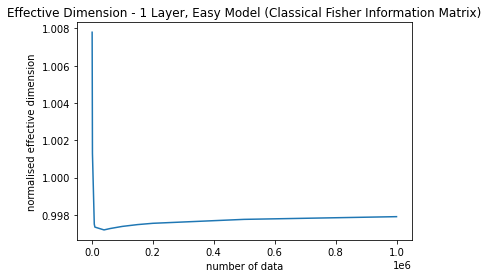

In [17]:
plt.plot(n, effdim)
plt.ylabel("normalised effective dimension")
plt.xlabel("number of data")
plt.title("Effective Dimension - 1 Layer, Easy Model (Classical Fisher Information Matrix)")

In [18]:
np.save("Data/2qubits_1layer_f_hats_pauli.npy", f)
np.save("Data/2qubits_1layer_effective_dimension_pauli.npy", effdim)